In [1]:
import pycisTopic
import glob
import os
import pybiomart as pbm
import pandas as pd
import pickle
from pycisTopic.qc import *
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import multiprocess as mp  # for kde multithreading calculation
from multiprocess import Pool

%matplotlib inline
%load_ext lab_black

# Download annotation

In [2]:
!pwd

/dodrio/scratch/projects/starting_2022_023/benchmark/scatac_benchmark/public_1_cistopic_qc


In [3]:
wdir = "/dodrio/scratch/projects/starting_2022_023/benchmark/scatac_benchmark/public_1_cistopic_qc"
os.chdir(wdir)

In [4]:
genome = "mm10"

pbm_genome_name_dict = {
    "hg38": "hsapiens_gene_ensembl",
    "hg37": "hsapiens_gene_ensembl",
    "mm10": "mmusculus_gene_ensembl",
    "dm6": "dmelanogaster_gene_ensembl",
}

pbm_host_dict = {
    "hg38": "http://www.ensembl.org",
    "hg37": "http://grch37.ensembl.org/",
    "mm10": "http://nov2020.archive.ensembl.org/",
    "dm6": "http://www.ensembl.org",
}

if os.path.exists(f"annotation.tsv"):
    print(f"Loading cached genome annotation...")
    annotation = pd.read_csv("annotation.tsv", sep="\t", header=0, index_col=0)
else:
    dataset = pbm.Dataset(name=pbm_genome_name_dict[genome], host=pbm_host_dict[genome])

    annotation = dataset.query(
        attributes=[
            "chromosome_name",
            "transcription_start_site",
            "strand",
            "external_gene_name",
            "transcript_biotype",
        ]
    )
    filter = annotation["Chromosome/scaffold name"].str.contains("CHR|GL|JH|MT")
    annotation = annotation[~filter]
    annotation["Chromosome/scaffold name"] = annotation[
        "Chromosome/scaffold name"
    ].str.replace(r"(\b\S)", r"chr\1")
    annotation.columns = ["Chromosome", "Start", "Strand", "Gene", "Transcript_type"]
    annotation = annotation[annotation.Transcript_type == "protein_coding"]
    annotation.to_csv("annotation.tsv", sep="\t")

Loading cached genome annotation...


In [5]:
fragments_list = sorted(
    glob.glob("../1_data_repository/publicdata_full_fragments/*.tsv.gz")
)
fragments_dict = {}
for fragments_file in fragments_list:
    sample = fragments_file.split("/")[-1].split("_fragments.tsv.gz")[0]
    fragments_dict[sample] = fragments_file

In [6]:
fragments_list_ddseq = sorted(
    glob.glob("../1_data_repository/publicdata_full_fragments/ddseq/*.tsv.gz")
)
fragments_dict_ddseq = {}
for fragments_file in fragments_list_ddseq:
    sample = fragments_file.split("/")[-1].split(".fragments.tsv.gz")[0]
    fragments_dict_ddseq[sample] = fragments_file
fragments_dict_ddseq

{'GSM3507342_Mouse1-Channel1': '../1_data_repository/publicdata_full_fragments/ddseq/GSM3507342_Mouse1-Channel1.fragments.tsv.gz',
 'GSM3507343_Mouse1-Channel2': '../1_data_repository/publicdata_full_fragments/ddseq/GSM3507343_Mouse1-Channel2.fragments.tsv.gz',
 'GSM3507344_Mouse1-Channel3': '../1_data_repository/publicdata_full_fragments/ddseq/GSM3507344_Mouse1-Channel3.fragments.tsv.gz',
 'GSM3507345_Mouse1-Channel4': '../1_data_repository/publicdata_full_fragments/ddseq/GSM3507345_Mouse1-Channel4.fragments.tsv.gz',
 'GSM3507346_Mouse1-Channel5': '../1_data_repository/publicdata_full_fragments/ddseq/GSM3507346_Mouse1-Channel5.fragments.tsv.gz',
 'GSM3507347_Mouse1-Channel6': '../1_data_repository/publicdata_full_fragments/ddseq/GSM3507347_Mouse1-Channel6.fragments.tsv.gz',
 'GSM3507348_Mouse1-Channel7': '../1_data_repository/publicdata_full_fragments/ddseq/GSM3507348_Mouse1-Channel7.fragments.tsv.gz',
 'GSM3507349_Mouse2-Channel1': '../1_data_repository/publicdata_full_fragments/ddse

In [7]:
fragments_dict.update(fragments_dict_ddseq)

In [8]:
fragments_dict

{'8k_mouse_cortex_ATACv1p1_nextgem_Chromium_X': '../1_data_repository/publicdata_full_fragments/8k_mouse_cortex_ATACv1p1_nextgem_Chromium_X_fragments.tsv.gz',
 '8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller': '../1_data_repository/publicdata_full_fragments/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_fragments.tsv.gz',
 '8k_mouse_cortex_ATACv2_nextgem_Chromium_X': '../1_data_repository/publicdata_full_fragments/8k_mouse_cortex_ATACv2_nextgem_Chromium_X_fragments.tsv.gz',
 'atac_v1_adult_brain_fresh_5k': '../1_data_repository/publicdata_full_fragments/atac_v1_adult_brain_fresh_5k_fragments.tsv.gz',
 'e18_mouse_brain_fresh_5k_atac': '../1_data_repository/publicdata_full_fragments/e18_mouse_brain_fresh_5k_atac_fragments.tsv.gz',
 'GSM3507342_Mouse1-Channel1': '../1_data_repository/publicdata_full_fragments/ddseq/GSM3507342_Mouse1-Channel1.fragments.tsv.gz',
 'GSM3507343_Mouse1-Channel2': '../1_data_repository/publicdata_full_fragments/ddseq/GSM3507343_Mouse1-Channel2.fragments.

The regions we will count in. Here, I count everything in the human ENCODE SCREEN regions. You can also add a sample-specific region set, e.g. sample-specific peaks called on the sample's bams.

In [9]:
region = "../0_resources/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed"

Now, make a sub dictionary of all samples within the fragments dict that have not been run yet (good for resuming a stopped cistopic run):

In [10]:
cistopic_qc_out = os.path.join(wdir, "cistopic_qc_out")
if not os.path.exists(cistopic_qc_out):
    os.makedirs(cistopic_qc_out)

In [11]:
fragments_sub_dict = {}
regions_sub_dict = {}
for sample in fragments_dict:
    metadata_file = os.path.join(cistopic_qc_out, sample + "__metadata_bc.pkl")
    print(f"Checking if {metadata_file} exist...")
    if os.path.exists(metadata_file):
        print("\tMetadata exists! Skipping...")
    else:
        fragments_sub_dict[sample] = fragments_dict[sample]
        print("\tMetadata does not exist, adding to subdict to generate")
        regions_sub_dict = {x: region for x in sorted(fragments_sub_dict.keys())}

Checking if /dodrio/scratch/projects/starting_2022_023/benchmark/scatac_benchmark/public_1_cistopic_qc/cistopic_qc_out/8k_mouse_cortex_ATACv1p1_nextgem_Chromium_X__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if /dodrio/scratch/projects/starting_2022_023/benchmark/scatac_benchmark/public_1_cistopic_qc/cistopic_qc_out/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if /dodrio/scratch/projects/starting_2022_023/benchmark/scatac_benchmark/public_1_cistopic_qc/cistopic_qc_out/8k_mouse_cortex_ATACv2_nextgem_Chromium_X__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if /dodrio/scratch/projects/starting_2022_023/benchmark/scatac_benchmark/public_1_cistopic_qc/cistopic_qc_out/atac_v1_adult_brain_fresh_5k__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if /dodrio/scratch/projects/starting_2022_023/benchmark/scatac_benchmark/public_1_cistopic_qc/cistopic_qc_out/e18_mouse_brain

In [12]:
ray.shutdown()

In [ ]:
n_cores = 8
if fragments_sub_dict != {}:
    samples_sub = list(fragments_sub_dict.keys())
    blocks = [samples_sub[i : i + n_cores] for i in range(0, len(samples_sub), n_cores)]
    for samples_torun_in_block in blocks:
        fragments_sub_dict_block = {
            key: fragments_sub_dict[key] for key in samples_torun_in_block
        }
        regions_sub_dict_block = {
            key: regions_sub_dict[key] for key in samples_torun_in_block
        }

        metadata_bc_dict, profile_data_dict = compute_qc_stats(
            fragments_dict=fragments_sub_dict_block,
            tss_annotation=annotation,
            stats=[
                "barcode_rank_plot",
                "duplicate_rate",
                "insert_size_distribution",
                "profile_tss",
                "frip",
            ],
            label_list=None,
            path_to_regions=regions_sub_dict_block,
            n_cpu=n_cores,
            valid_bc=None,
            n_frag=10,
            n_bc=None,
            tss_flank_window=2000,
            tss_window=50,
            tss_minimum_signal_window=100,
            tss_rolling_window=10,
            # min_norm=0.2,
            remove_duplicates=True,
        )

        ray.shutdown()
        print(f"Dumping files in {cistopic_qc_out}...")
        for sample in sorted(metadata_bc_dict.keys()):
            metadata_bc_dict[sample]["sample_id"] = sample
            metadata_bc_dict[sample].index = [
                x + "___" + sample for x in list(metadata_bc_dict[sample].index)
            ]
            with open(
                os.path.join(cistopic_qc_out, f"{sample}__metadata_bc.pkl"), "wb"
            ) as f:
                pickle.dump(metadata_bc_dict[sample], f, protocol=4)

            with open(
                os.path.join(cistopic_qc_out, f"{sample}__profile_data.pkl"), "wb"
            ) as f:
                pickle.dump(profile_data_dict[sample], f, protocol=4)
else:
    print("All samples already processed.")

# Plot

Calculating a KDE is simultaneously expensive and scales poorly with increasing n. Therefore, I wrote a multithreaded script that divides the QC array into equal parts (interleaved to avoid biases in the order!) and performs a KDE calculation on each part. Here, Otsu thresholding is used to find the right threshold for minimum fragments and minimum TSS enrichment. ddseq samples have a significantly higher noise floor than the other samples when it comes to fragment distribution. Therefore, the otsu algorithm is performed on all barcodes with a minimum of 300 fragments for the ddseq samples, and a minimum of 100 fragments for all the other samples. I tried to perform this filtering completely independent of sample/technique (e.g. using gaussian mixture modeling, Jenks natural breaks, or multiple step Otsu thresholding) but found that no solution worked perfectly for all samples.

This is regulated by the code below in qc_plots.py:
```
min_otsu_frags_dict = {}
for fragments_file in fragments_list:
    sample = fragments_file.split("/")[-1].split(".")[0]
    tech = sample.split('_')[1]
    if tech == "ddseq":
        if sample == "BIO_ddseq_1":
            min_otsu_frags_dict[sample] = 600
        else:
            min_otsu_frags_dict[sample] = 300
    elif tech == "hydrop":
        min_otsu_frags_dict[sample] = 300
    else:
        min_otsu_frags_dict[sample] = 100
```

In [ ]:
!cat ../0_resources/scripts/qc_plots.py

Since multiprocessing does not work with jupyter notebooks, run the following code in terminal:

```
mkdir plots_qc
mkdir selected_barcodes
SIF=../0_resources/cistopic_image/20220722_pycistopic.sif
singularity exec \
    --cleanenv \
    -H $PWD:/home \
    $SIF \
    python ../0_resources/scripts/qc_plots.py
```

And then open the plots:

8k_mouse_cortex_ATACv1p1_nextgem_Chromium_X bc passing filters exists, printing img and skipping


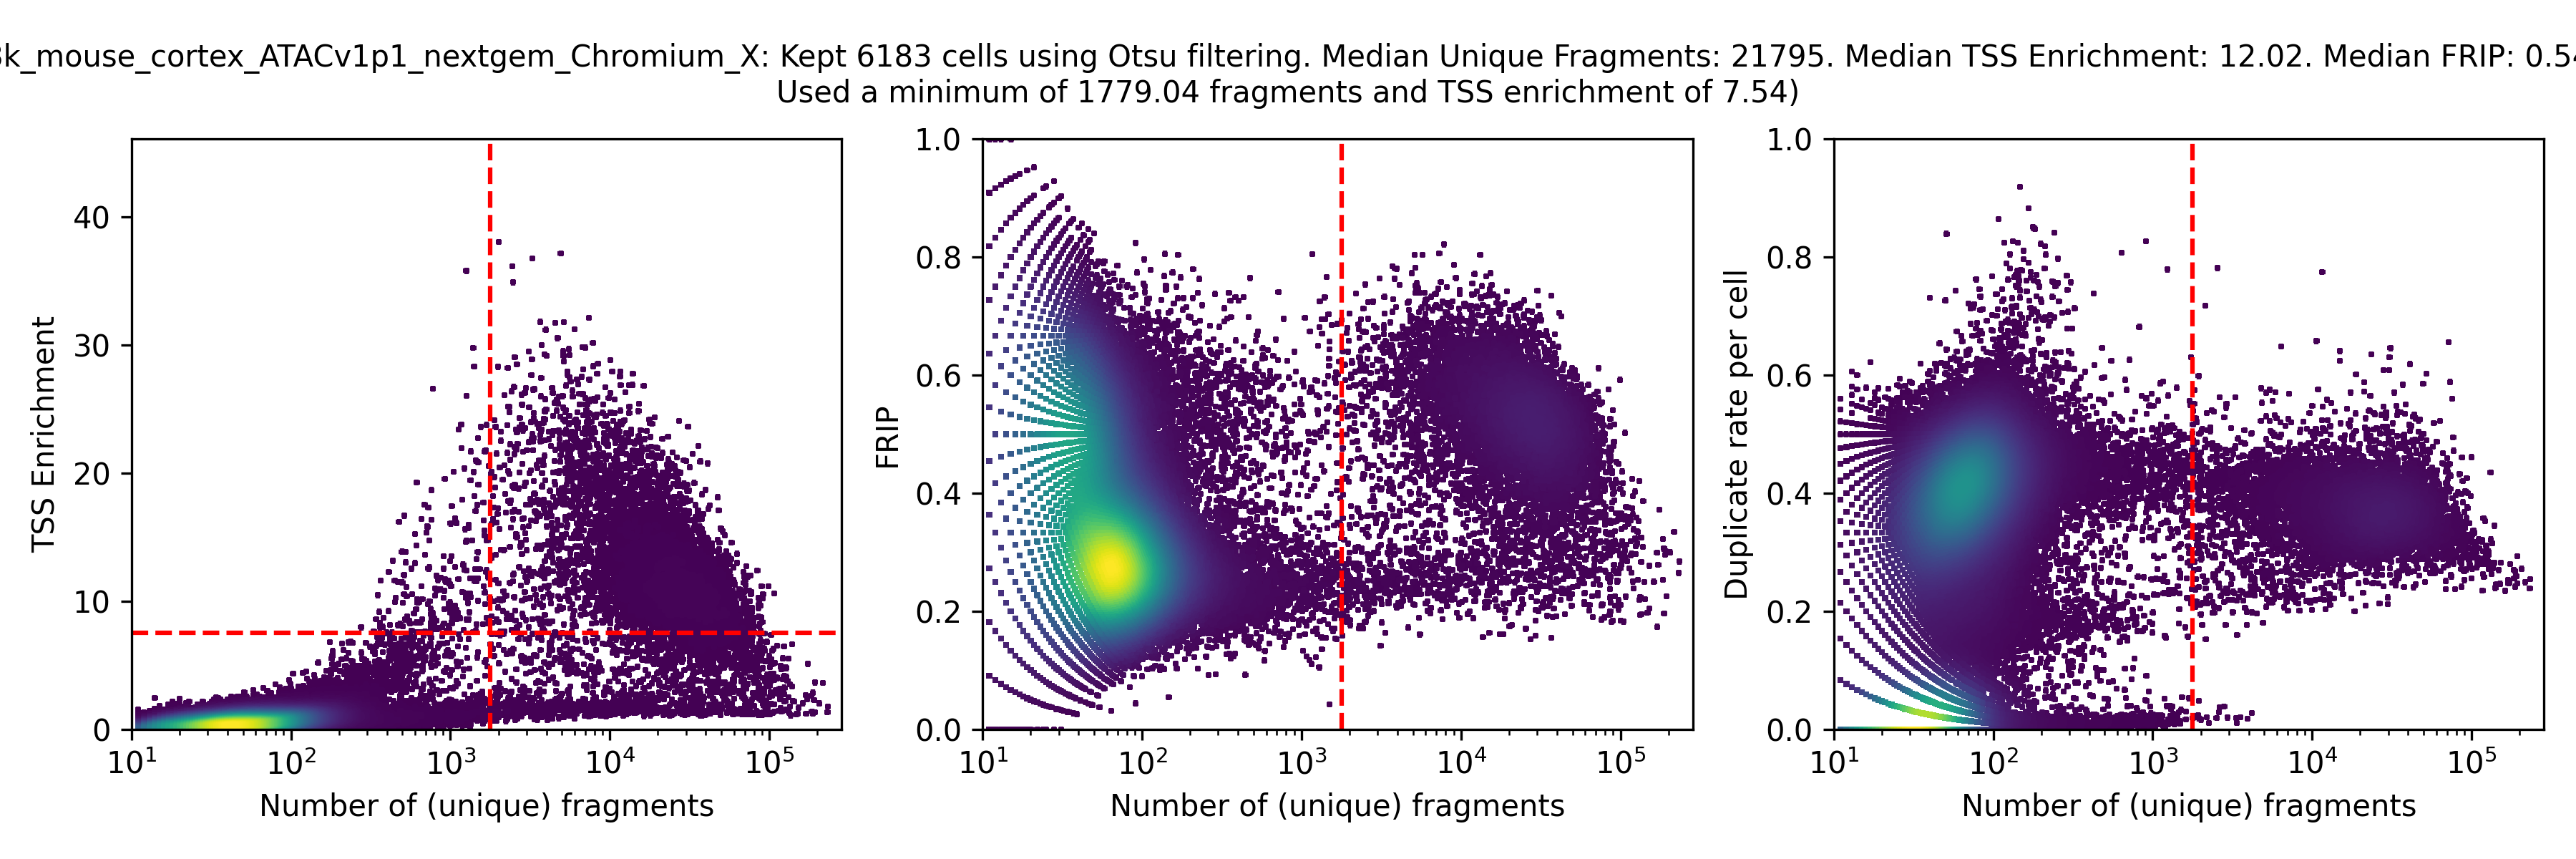

8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller bc passing filters exists, printing img and skipping


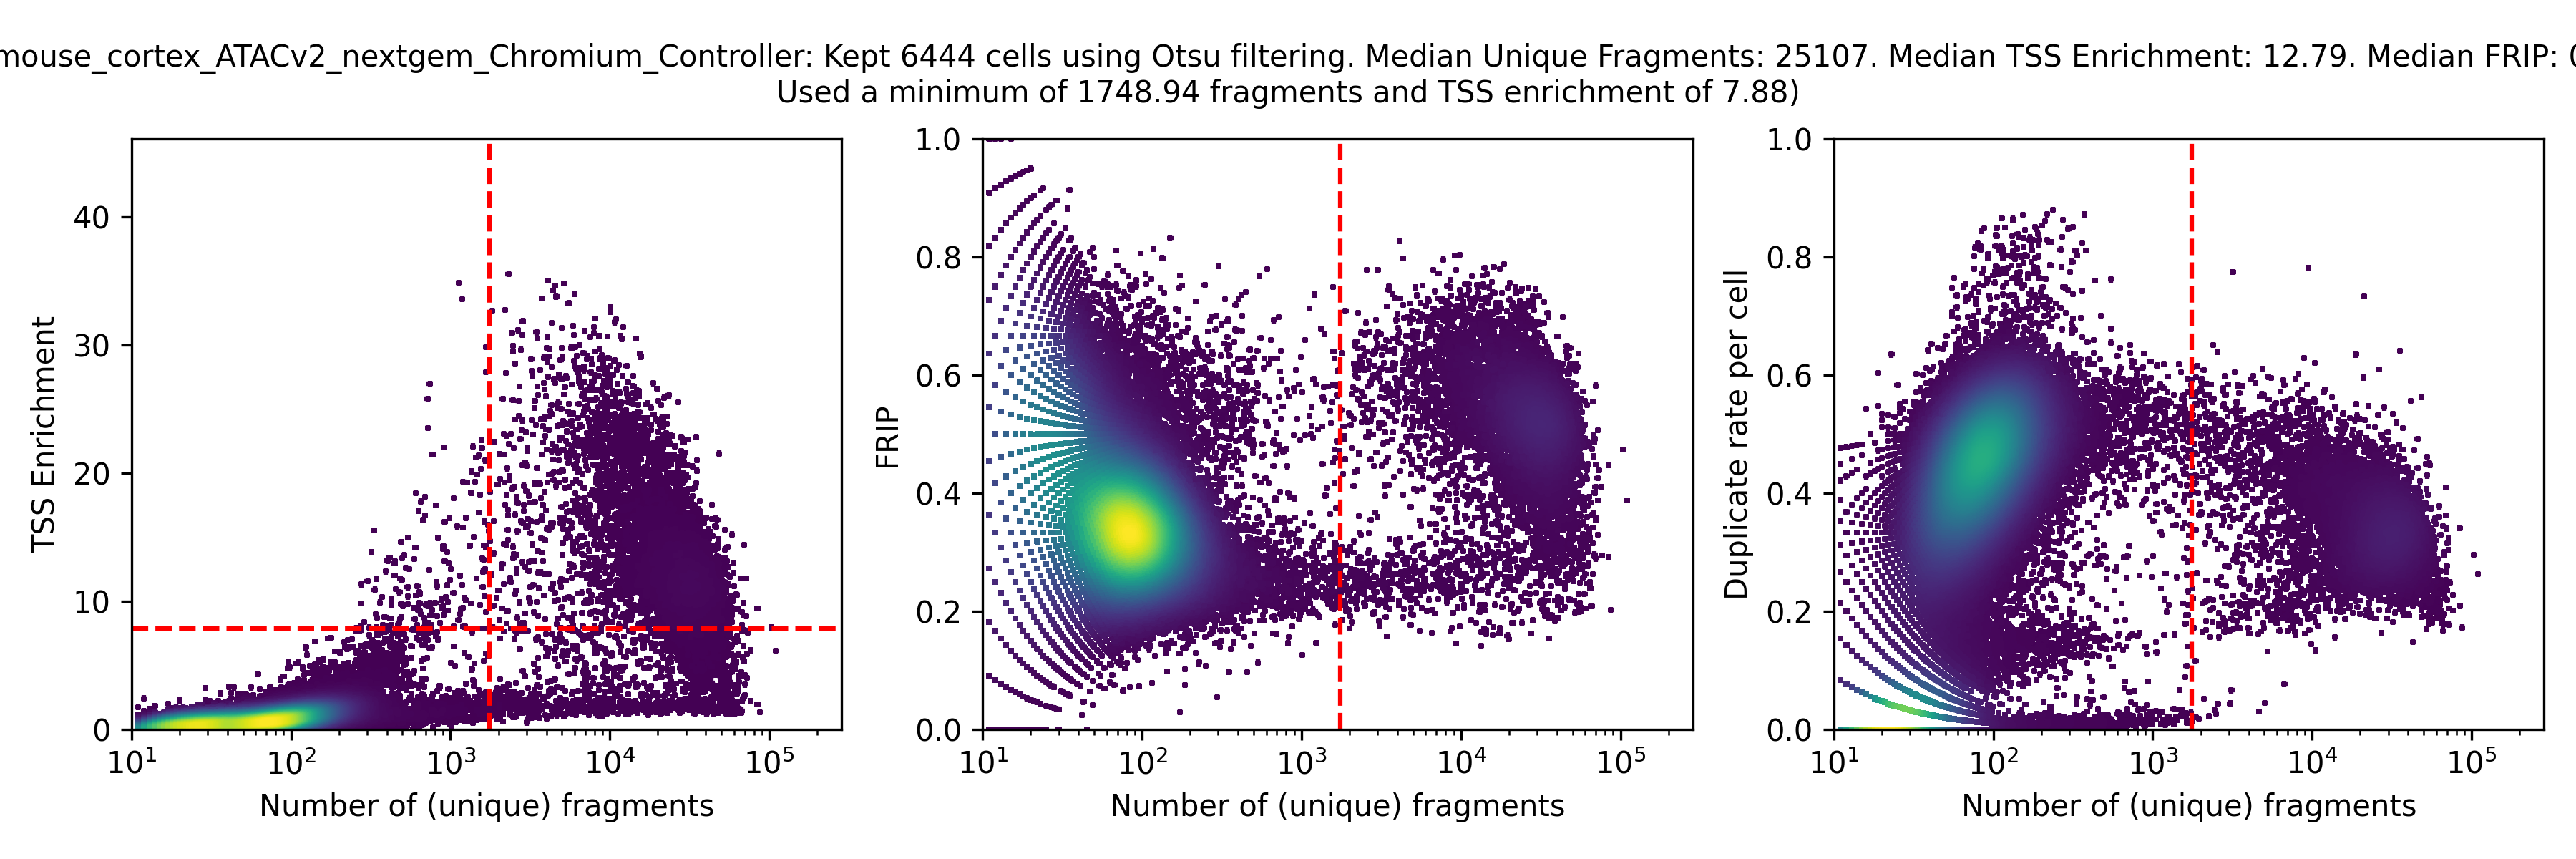

8k_mouse_cortex_ATACv2_nextgem_Chromium_X bc passing filters exists, printing img and skipping


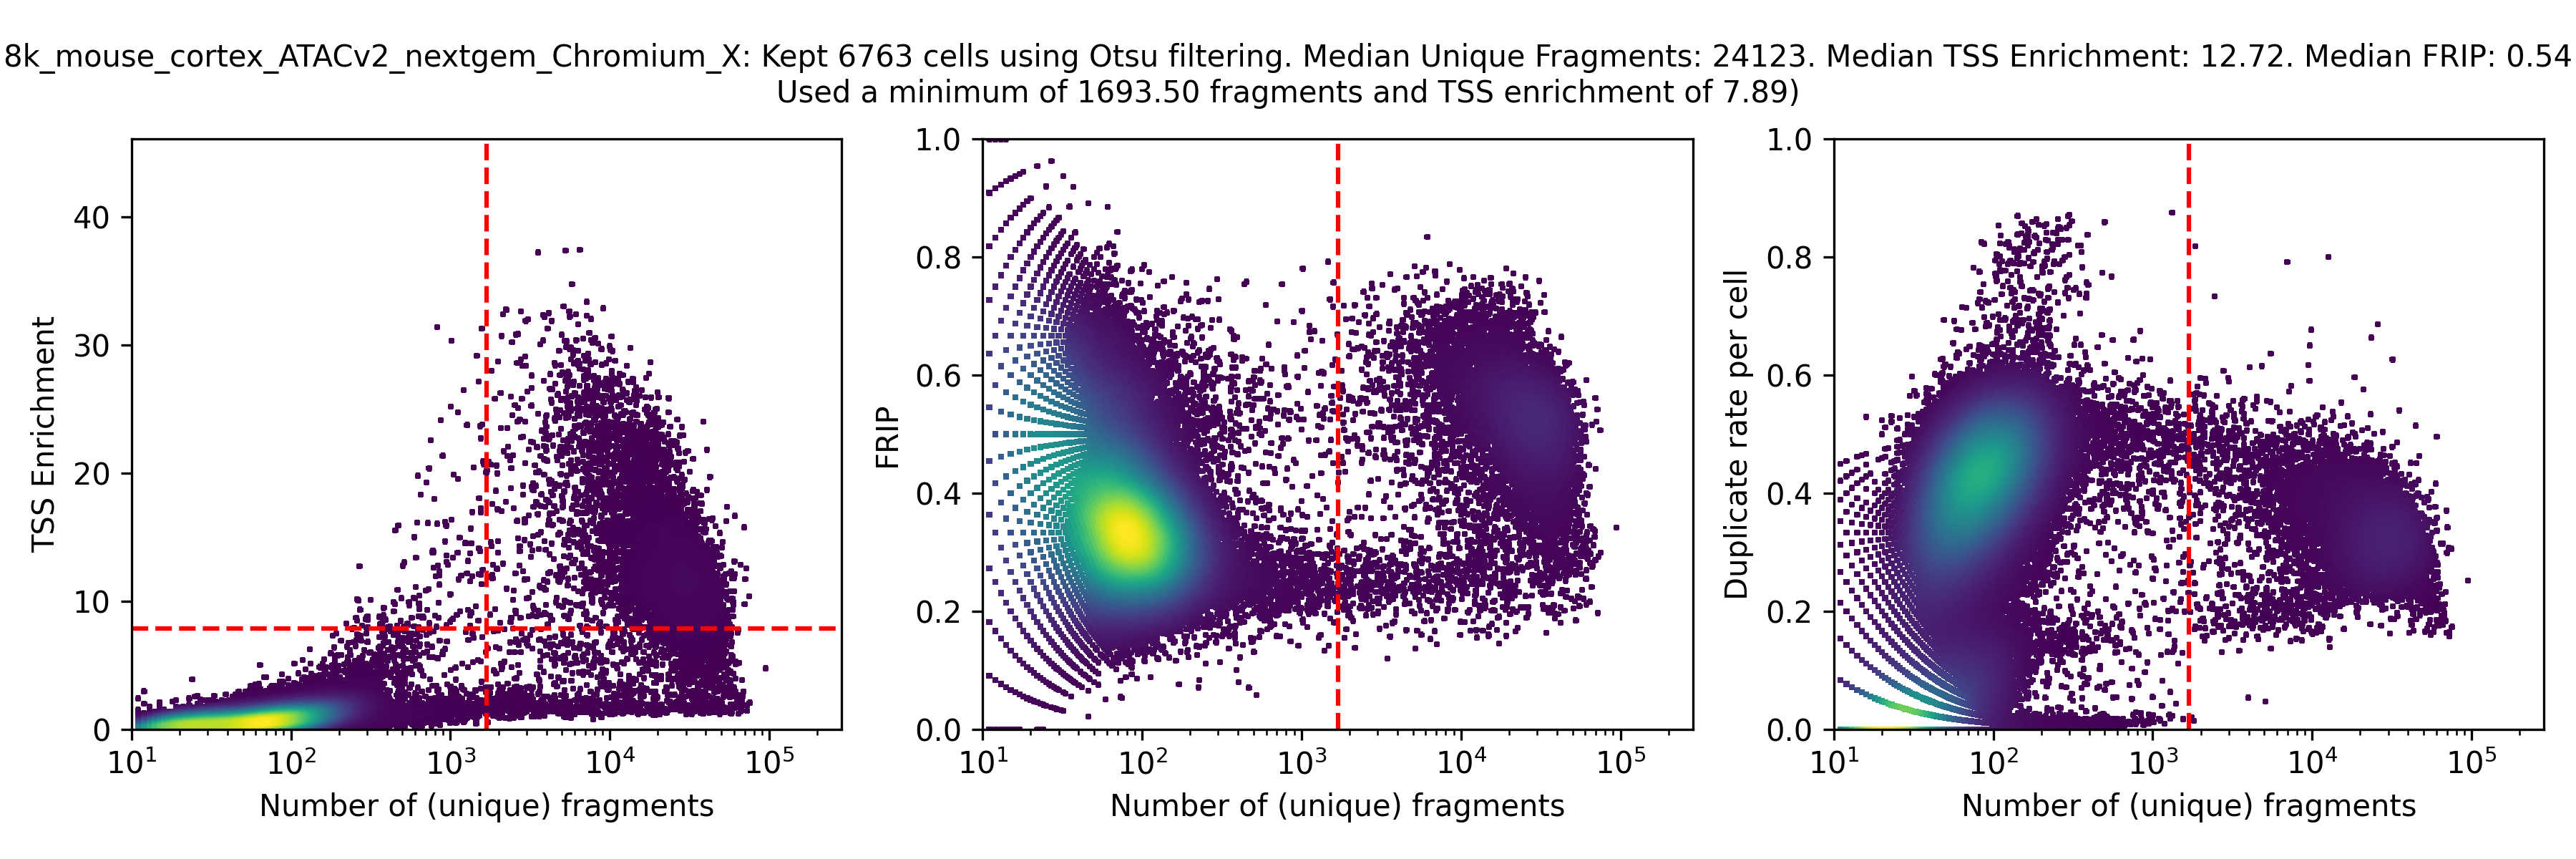

atac_v1_adult_brain_fresh_5k bc passing filters exists, printing img and skipping


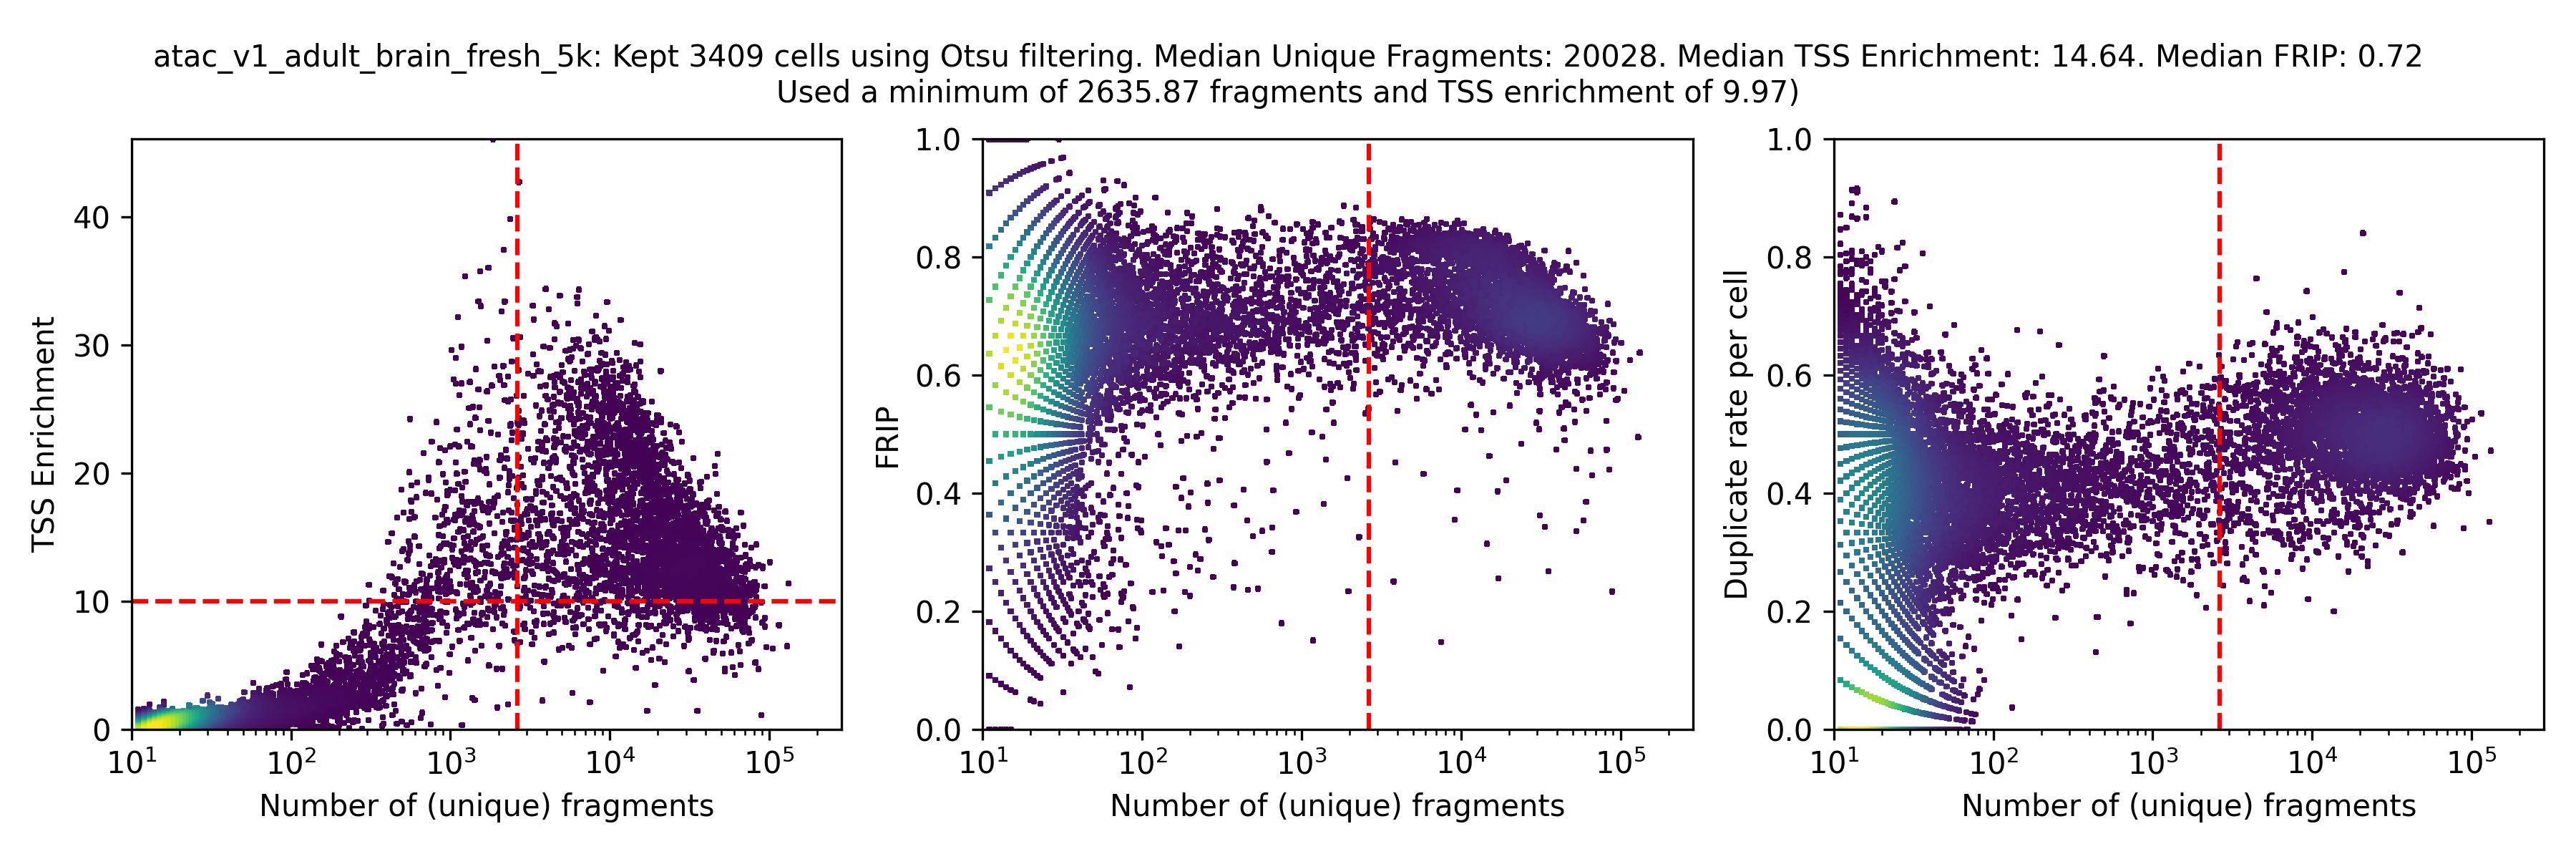

e18_mouse_brain_fresh_5k_atac bc passing filters exists, printing img and skipping


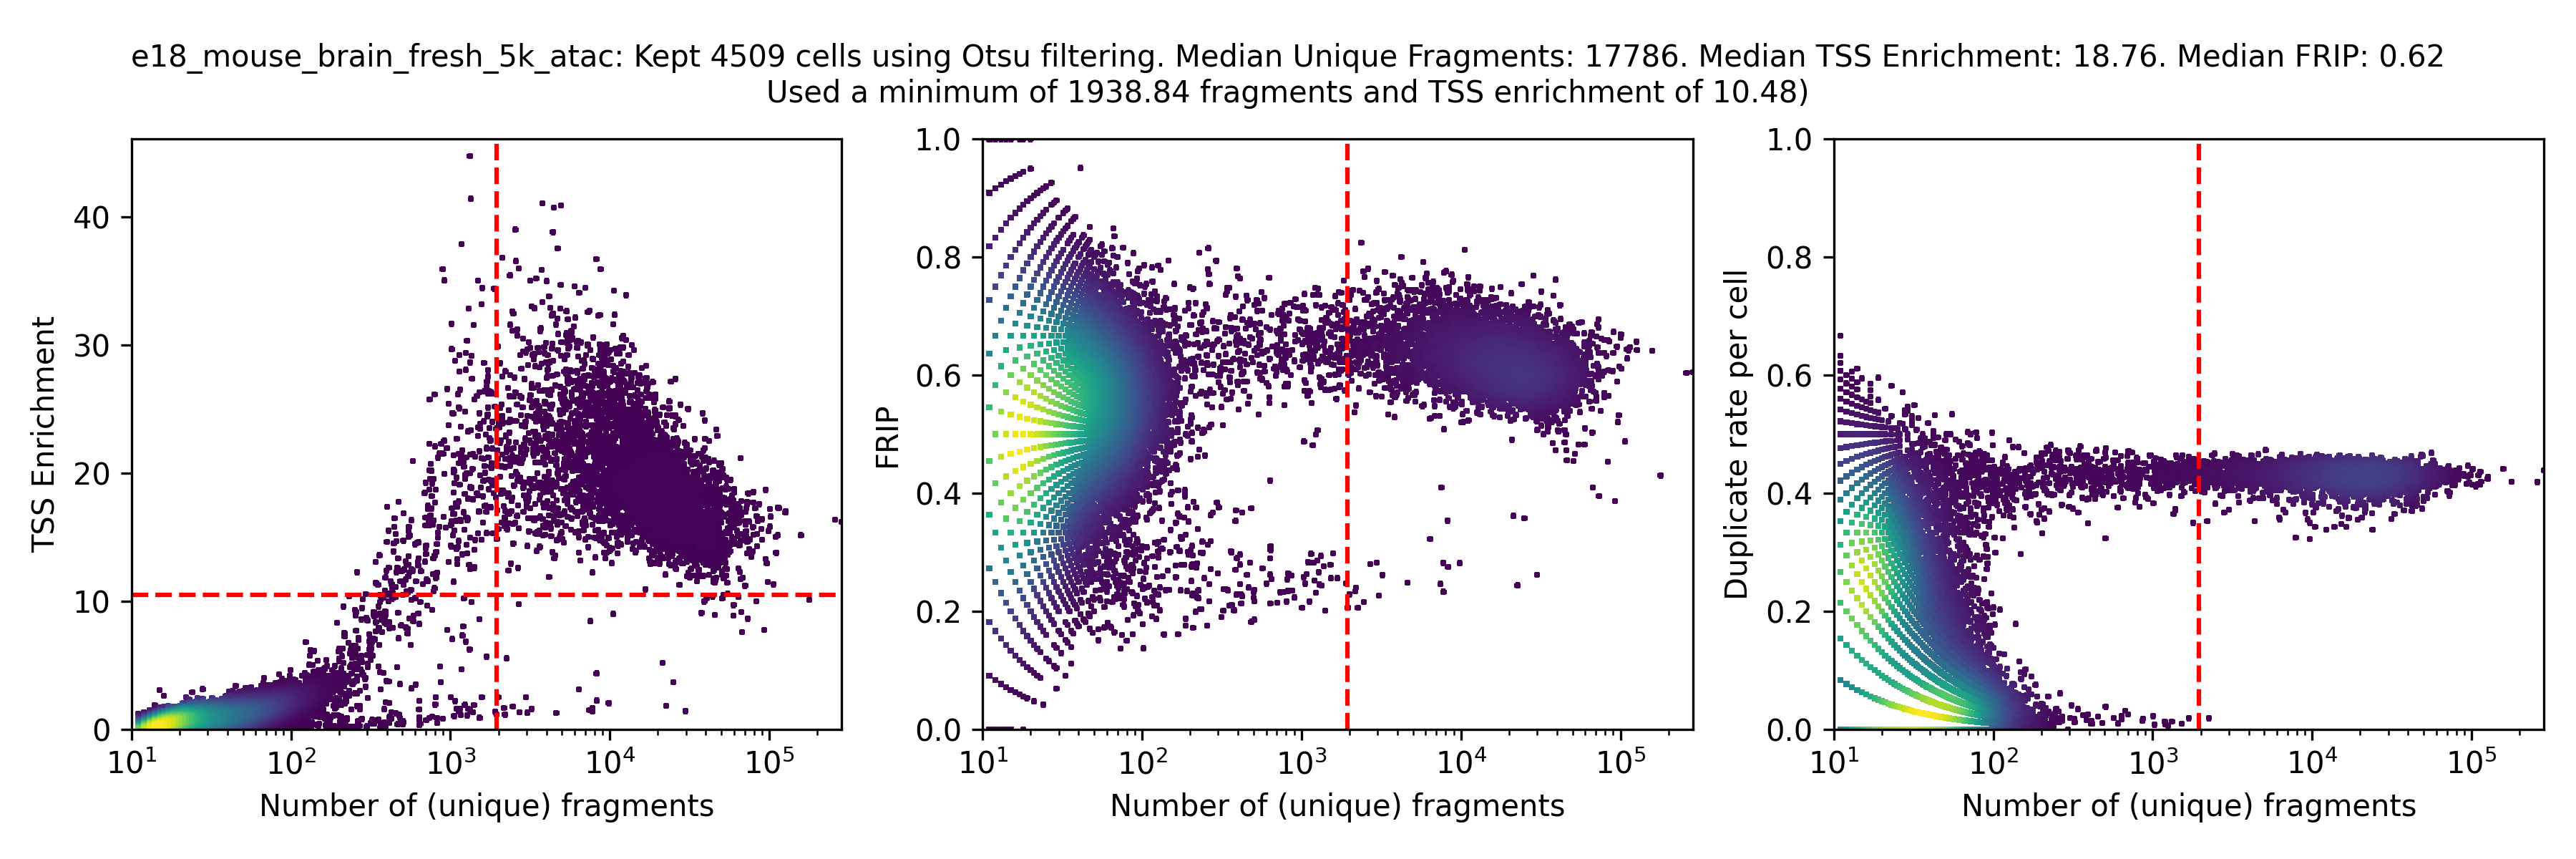

In [4]:
metadata_bc_pkl_list = sorted(glob.glob("cistopic_qc_out/*metadata_bc.pkl"))
metadata_bc_pkl_path_dict = {}
for metadata_bc_pkl_path in metadata_bc_pkl_list:
    sample = metadata_bc_pkl_path.split("/")[-1].split(".")[0].split("__")[0]
    metadata_bc_pkl_path_dict[sample] = metadata_bc_pkl_path

for sample in metadata_bc_pkl_path_dict.keys():
    if os.path.exists(f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl"):
        print(f"{sample} bc passing filters exists, printing img and skipping")
        display(Image(f"plots_qc/{sample}_qc_otsu.png"))
    else:
        print(
            f"{sample} bc passing filters does not exist yet, generate using qc_plots.py script!"
        )